In [18]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image
from PIL import UnidentifiedImageError
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

%matplotlib inline

Preprocessing del dataset, no hay que volver a correrlo

In [6]:
from google.colab import files
uploaded = files.upload()

/home/lautaro/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


n_cats: 12496  n_dogs: 12497  data shape: (24993, 50, 50, 3)


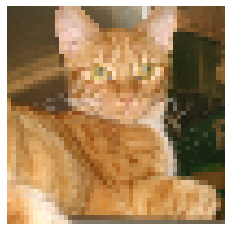

In [4]:
pathw = 'C:\\Users\\Lautaro\\Desktop\\Lautaro\\asd\\2021\\Doctorado\\Materias\\Deep Learning (2020)\\Datos\\CatsvDogs'
pathl = '/home/lautaro/Desktop/Workspace/Deep_Learning/Data/CatsvDogs'

cats = os.path.join(pathl, 'Cat')
dogs = os.path.join(pathl, 'Dog')

data = []

for cat in os.listdir(cats):
    try:
        curr_img = image.imread(os.path.join(cats, cat))
        res_img = resize(curr_img, (50, 50), anti_aliasing=0)
        shape = res_img.shape
        if shape == (50,50,3):
            data.append(res_img)

        #A veces lee imagenes con formato RGBA, saco el ultimo canal (lleno de 1s)
        elif shape == (50,50,4):
            data.append(res_img[...,:3])

    except UnidentifiedImageError:
        pass

n_cats = len(data)
y = np.zeros((n_cats))

for dog in os.listdir(dogs):
    try:
        curr_img = image.imread(os.path.join(dogs, dog))
        res_img = resize(curr_img, (50, 50), anti_aliasing=0)
        shape = res_img.shape
        if shape == (50,50,3):
            data.append(res_img)
        elif shape == (50,50,4):
            data.append(res_img[...,:3])
          
    except UnidentifiedImageError:
        pass
        

n_dogs = len(data) - n_cats
y = np.append(y, np.ones((n_dogs)))

data = np.stack(data, axis=0)


print('n_cats:', n_cats, ' n_dogs:', n_dogs, ' data shape:', data.shape)
plt.imshow(data[143])
plt.axis('off');

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [6]:
save_path = '/home/lautaro/Desktop/Workspace/Deep_Learning/Data/P5/Ej_1'

np.save(os.path.join(save_path, 'xtrain.npy'), X_train)
np.save(os.path.join(save_path, 'xtest.npy'), X_test)
np.save(os.path.join(save_path, 'ytrain.npy'), y_train)
np.save(os.path.join(save_path, 'ytest.npy'), y_test)

In [22]:
#Aumentacion de datos
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=(-0.2, 0.2)),
        keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), 
                                       width_factor=(-0.2, 0.2)),
    ]
)

# Create a tf.data pipeline of augmented images (and their labels)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

AttributeError: module 'tensorflow.keras.layers.experimental' has no attribute 'RandomFlip'

: 

In [ ]:
def plot(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    ax1.plot(hist.history['loss'], label='CCE')
    ax1.plot(hist.history['val_loss'], label='val_CCE')
    ax1.set_xlabel('Epocas', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.legend(loc='best')

    ax2.plot(hist.history['sparse_categorical_accuracy'], label='acc')
    ax2.plot(hist.history['val_sparse_categorical_accuracy'], label='val_acc')
    ax2.set_xlabel('Epocas', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.legend(loc='best')

    fig.tight_layout()
    plt.show()
    return None

In [ ]:
keras.backend.clear_session()

reg = keras.regularizers.L2(l2=1e-3)
drop_r = 0.4

model = keras.models.Sequential(name='AlexNet')

#Capas convolucionales

model.add(keras.layers.Input(shape=(32,32,3)))
model.add(keras.layers.Rescaling(1.0 / 255))

model.add(keras.layers.Conv2D(128, 5, strides=1, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=1))

model.add(keras.layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2))

model.add(keras.layers.Conv2D(352, 3, strides=2, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(352, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(256, 3, strides=1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=drop_r))


#Capas densas

model.add(keras.layers.Dense(2048, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(rate=drop_r))
model.add(keras.layers.Dense(2048, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(rate=drop_r))
model.add(keras.layers.Dense(10, activation='softmax', kernel_regularizer=reg))

model.summary()

In [19]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

def scheduler(epoch, lr):
  if epoch==10 or epoch == 25 or epoch == 50 or epoch == 75:
    return lr/3
  else:
    return lr


callbacks_list=[
    keras.callbacks.LearningRateScheduler(
    scheduler, verbose=0
    ),
    ClearMemory(),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
]

In [ ]:
opt = keras.optimizers.Adam(learning_rate=.0003)


model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

hist = model.fit(train_dataset, validation_data=(x_test, y_test), 
                 callbacks=callbacks_list, epochs=100, verbose=1)